In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root = "./data", train = True, download = True, transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 32, shuffle = True)

testset = datasets.FashionMNIST(root = "./data", train = False, download = True, transform = tensor_transform)
testloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1000, shuffle = False)

0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...


/Users/martinm/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-x1rp5px8/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


## MLP

In [4]:
class AESimple(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # YOUR CODE

        
        
        
        
        # YOUR CODE
  
    def forward(self, x):
        # YOUR CODE

        
        
        
        
        # YOUR CODE


In [5]:
def train_eval(epochs, lr, model, loader, testloader):
    pelosses = []
    pelosses_test = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)

    for epoch in range(epochs):    
        peloss = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed = model(image)  
            loss = loss_function(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
        peloss /= len(loader)
        pelosses.append(peloss)
    
        pelosstest = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed = model(image)  
                pelosstest += loss_function(reconstructed, image).item()
            pelosstest /= len(testloader)
            pelosses_test.append(pelosstest)
        print("Epoch %i: %6.4f  %6.4f"%(epoch,peloss,pelosstest))
    return pelosses, pelosses_test

In [6]:
def plot_loss(pelosses, pelosses_test):
    plt.style.use('fivethirtyeight')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    epochs = len(pelosses)
    plt.semilogy(torch.arange(epochs)+1, pelosses, 'b-')
    plt.semilogy(torch.arange(epochs)+1, pelosses_test, 'r-')    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 784]         101,136
           Sigmoid-5                  [-1, 784]               0
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.77
Estimated Total Size (MB): 0.79
----------------------------------------------------------------
Epoch 0: 0.0213  0.0115
Epoch 1: 0.0100  0.0089
Epoch 2: 0.0083  0.0079


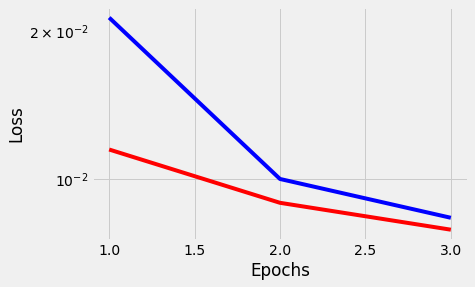

In [7]:
nepochs = 3
model = AESimple(128)
summary(model, (1,28,28))
pelosses, pelosses_test = train_eval(nepochs, 0.001, model, loader, testloader)
plot_loss(pelosses, pelosses_test)

In [8]:
def reconstruct(img, model):
    img = model(img)
    return img

def plot_img(img, title):
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

def plot_samples(dataset, models):
    n = 10
    m = len(models)
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        for j in range(m):
            figure.add_subplot(rows, cols, (j+1)*n+i+1)
            img, label = dataset[idx]
            img = reconstruct(img, models[j].to("cpu")).detach().numpy()
            plot_img(img, "")
    
    plt.show()

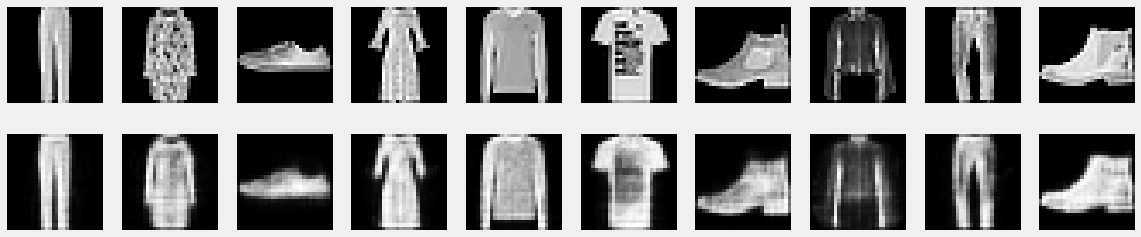

In [10]:
plot_samples(testset, [model])

In [11]:
def interpolate(img1, img2, model, d):
    n = 20
    lrow = int(n/2)
    
    model = model.to("cpu")

    img1 = img1.view(-1,1,28*28)
    z1 = model.encoder(img1)
    
    z1 = z1.view(-1,d)
    rec1 = model.decoder(z1)
    img2 = img2.view(-1,28*28)
    z2 = model.encoder(img2)
    z2 = z2.view(-1,d)
    rec2 = model.decoder(z2)
    
    imgs = [img1.detach().numpy(), rec1.detach().numpy()]
    for i in range(n-4):
        z = z1 + (z2-z1)*i/(n-4)
        img_dist = model.decoder(z).detach().numpy()
        imgs.append(img_dist)

    imgs.append(rec2.detach().numpy())
    imgs.append(img2.detach().numpy())

    plt.figure(figsize=(18, 4))
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1)
        plot_img(imgs[i].reshape(28,28), "")
    
    for i in range(lrow):
        ax = plt.subplot(2, lrow, i + 1 + lrow)
        plot_img(imgs[lrow+i].reshape(28,28), "")

plt.show()

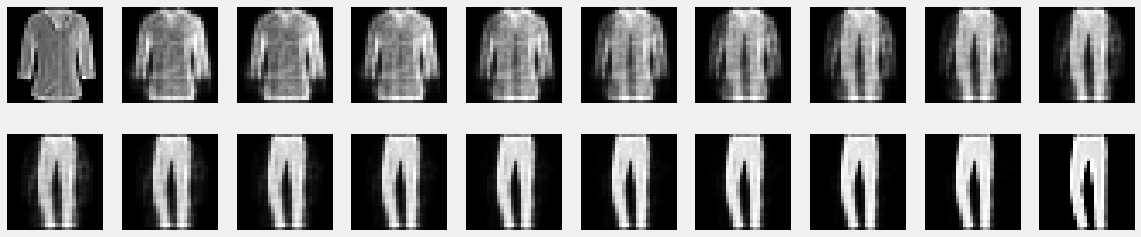

In [12]:
interpolate(testset[4][0], testset[2][0], model, 128)

In [13]:
def noise_added(inputs, model, sigma=0.2):
    n = 10
    m = len(inputs)
    to_plot = {}
    model = model.to("cpu")
    for j in range(m):
        img = inputs[j]
        z = model.encoder(img)
        rec = model.decoder(z)    
        imgs = [img.detach().numpy(), rec.detach().numpy()]
        for i in range(n-2):
            noise = sigma*torch.randn((model.latent_dim,))
            img_dist = model.decoder(z+noise).detach().numpy()
            imgs.append(img_dist)        
        to_plot[j] = imgs
        
    plt.figure(figsize=(20, m*2))
    ax = plt.subplot(m, n, 1)
    for j in range(m):
        for i in range(n):
            ax = plt.subplot(m, n, j*n+i+1)
            plot_img(to_plot[j][i].reshape(28,28), "")
        
    plt.show()

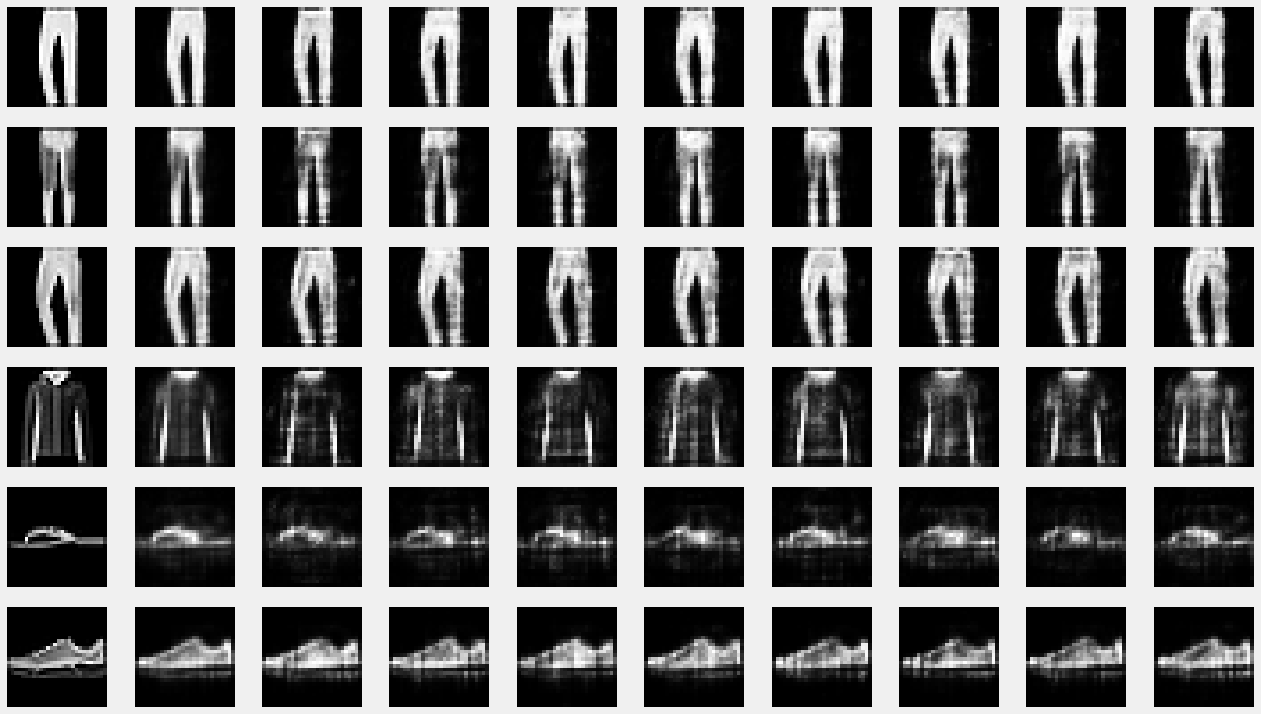

In [15]:
noise_added([testset[i][0] for i in [2,3,5,6,8,9]], model, sigma=0.5)

In [16]:
def generated(model, ld=None):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    d = model.latent_dim if hasattr(model,"latent_dim") else ld
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((d,)).view(-1,d)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

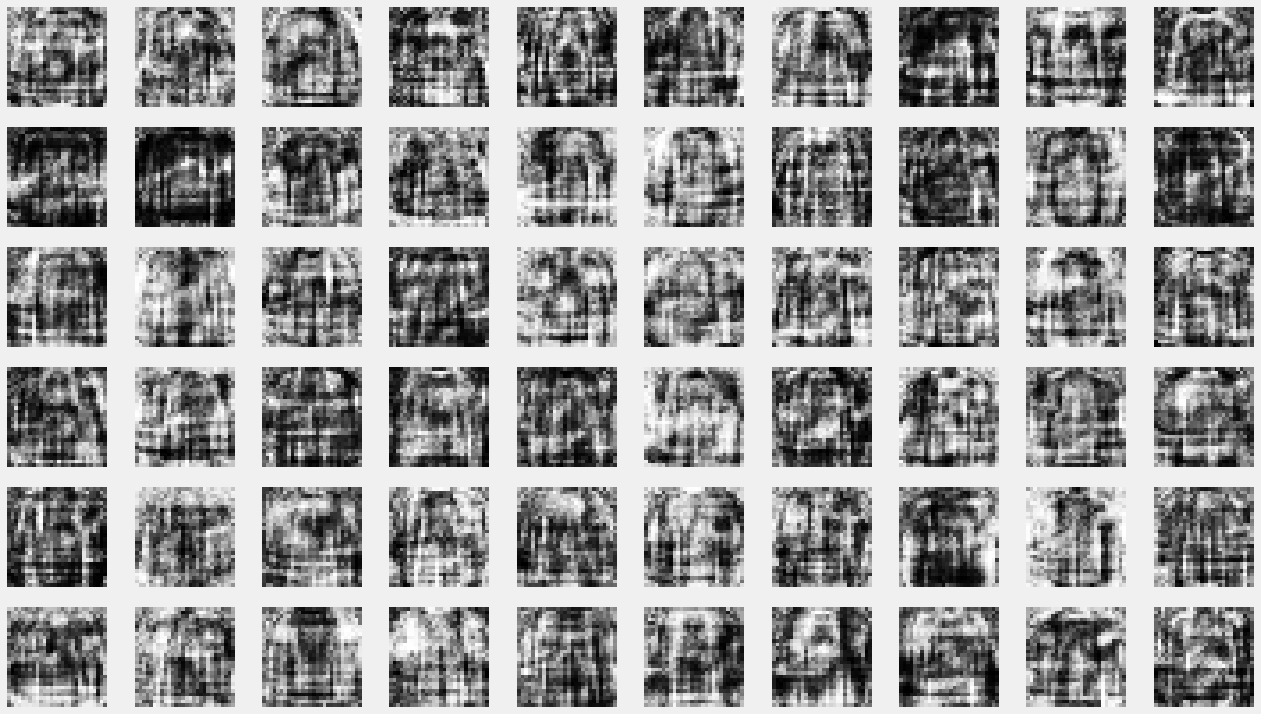

In [17]:
generated(model)

## CNN

In [18]:
class AECNN1(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # YOUR CODE

        
        
        
        
        
        
        
        
        
        # YOUR CODE
  
    def forward(self, x):
        # YOUR CODE

        
        
        
        
        
        
        
        
        # YOUR CODE
    

In [19]:
epochs = 3
lr = 0.001
model = AECNN1(128)
pelosses2, pelosses_test2 = train_eval(epochs, lr, model, loader, testloader)

Epoch 0: 0.0212  0.0131
Epoch 1: 0.0115  0.0103
Epoch 2: 0.0093  0.0085


In [ ]:
plot_loss(pelosses2, pelosses_test2)

In [ ]:
plot_samples(testset, [model])

In [ ]:
generated4cnn(model, 128)

## VAE

In [25]:
class VAECNN2(torch.nn.Module): 
    def __init__(self, latent_dim, beta=1.0):
        super().__init__()

        
        
        
        
        
        
        
        
        
        
        
        
        
        # YOUR CODE
  
    def forward(self, x):
        # YOUR CODE

        
        
        
        
        
        
        
        
        # YOUR CODE
    
    def loss(self, img, rec):
        # YOUR CODE
        # Compute the total loss (per batch): Reconstruction Loss + KL Loss
        
        
        
        
        
        
        # YOUR CODE
    
    def reconstruct(self, x):
        # YOUR CODE
        # Just take the mu as z (without sampling)
        
        
        
        # YOUR CODE


In [26]:
def train_eval_vae(epochs, lr, model, loader, testloader, decay_lr=0.9):
    pelosses = []
    pelosses_rec = []
    pelosses_kl = []
    pelosses_test = []
    pelosses_test_rec = []
    pelosses_test_kl = []

    model = model.to(device)
    loss_function = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) #, weight_decay = 1e-8)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_lr)
    
    for epoch in range(epochs):    
        peloss = 0.0
        peloss_rec = 0.0
        peloss_kl = 0.0
        for (image, _) in loader:
            image = image.to(device)
            reconstructed = model(image)  
            loss, recloss, klloss = model.loss(reconstructed, image)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            peloss += loss.item()
            peloss_rec += recloss.item()
            peloss_kl += klloss.item()
        peloss /= len(loader)
        peloss_rec /= len(loader)
        peloss_kl /= len(loader)
        pelosses.append(peloss)
        pelosses_rec.append(peloss_rec)
        pelosses_kl.append(peloss_kl)
        
        scheduler.step()
    
        testpeloss = 0.0
        testpeloss_rec = 0.0
        testpeloss_kl = 0.0
        with torch.no_grad():
            for (image,_) in testloader:
                image = image.to(device)
                reconstructed = model(image)  
                loss, recloss, klloss = model.loss(reconstructed, image)
                testpeloss += loss.item()
                testpeloss_rec += recloss.item()
                testpeloss_kl += klloss.item()
            testpeloss /= len(testloader)
            testpeloss_rec /= len(testloader)
            testpeloss_kl /= len(testloader)
            pelosses_test.append(testpeloss)
            pelosses_test_rec.append(testpeloss_rec)
            pelosses_test_kl.append(testpeloss_kl)
        print("Epoch %i: %6.4f  %6.4f %6.4f %6.4f %6.4f %6.4f"%(epoch, peloss, peloss_rec, peloss_kl, testpeloss, testpeloss_rec, testpeloss_kl))
    return pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl

In [27]:
epochs = 3
lr = 0.001
vae = VAECNN2(128)
pelosses, pelosses_rec, pelosses_kl, pelosses_test, pelosses_test_rec, pelosses_test_kl \
                                        = train_eval_vae(epochs, lr, vae, loader, testloader,decay_lr=1.0)

Epoch 0: 0.0526  0.0438 0.0088 0.0424 0.0343 0.0081
Epoch 1: 0.0390  0.0303 0.0086 0.0372 0.0291 0.0081
Epoch 2: 0.0355  0.0269 0.0086 0.0344 0.0259 0.0086


In [ ]:
plt.figure(figsize=(18,12))
plt.xlabel('Epochs')
plt.ylabel('Loss')
epochs = len(pelosses)
plt.plot(torch.arange(epochs)+1, pelosses, 'b-', label="train_loss")
plt.plot(torch.arange(epochs)+1, pelosses_test, 'r-',label="test_loss")    
plt.bar(torch.arange(epochs)+1, pelosses_test_rec, label="test_loss_rec")
plt.bar(torch.arange(epochs)+1, pelosses_test_kl, bottom=pelosses_test_rec, label="test_loss_kl")
plt.legend()

In [29]:
def plot_samples_vae(dataset, model):
    n = 10
    m = 1
    model.to("cpu")
    indices = torch.randint(len(dataset), size=(n,))
    cols, rows = n, m+1
    figure = plt.figure(figsize=(18, (m+1)*2))
    for i in range(n):
        idx = indices[i].item()
        img, label = dataset[idx]
        figure.add_subplot(rows, cols, i+1)
        plot_img(img.numpy(), "")
    
        figure.add_subplot(rows, cols, n+i+1)
        img, label = dataset[idx]
        img = model.reconstruct(img).detach().numpy()
        plot_img(img, "")    
    plt.show()

In [ ]:
plot_samples_vae(testset, vae)

In [31]:
def generated(model):
    cols = 10
    rows = 6
    model = model.to("cpu")
    plt.figure(figsize=(20, rows*2))
    ax = plt.subplot(rows, cols, 1)
    for j in range(rows):
        for i in range(cols):
            z = torch.randn((model.d,)).view(-1,model.d,1,1)
            rec = model.decoder(z).detach().numpy()        
            ax = plt.subplot(rows, cols, j*cols+i+1)
            plot_img(rec.reshape(28,28), "")
        
    plt.show()

In [ ]:
generated(vae)